## Final Project Group 105 

**Project Title:** Optimizing Fertility Care through the Integration of IVF and ML

**Group Members:** Shreya Modi, Ashvika Boopathy, Tania Gole

**Date:** December 6th 2024

# Data Cleaning & Preprocessing

In [1]:
import pandas as pd
from sklearn import preprocessing
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

filterwarnings("ignore")

In [22]:
# Define the data cleaning function
def clean_data(input_file, output_file):
    # Load data
    df = pd.read_csv(input_file)

    # Select columns to keep
    columns_to_keep = [
        'Patient Age at Treatment', 
        'Total Number of Previous IVF cycles', 
        'Total number of IVF pregnancies',
        'Total number of live births - conceived through IVF',
        'Type of Infertility - Female Primary',
        'Type of Infertility - Female Secondary',
        'Type of Infertility - Male Primary',
        'Type of Infertility - Male Secondary',
        'Type of Infertility -Couple Primary',
        'Type of Infertility -Couple Secondary',
        'Cause  of Infertility - Tubal disease',
        'Cause of Infertility - Ovulatory Disorder',
        'Cause of Infertility - Male Factor',
        'Cause of Infertility - Patient Unexplained',
        'Cause of Infertility - Endometriosis',
        'Cause of Infertility - Cervical factors',
        'Cause of Infertility - Female Factors',
        'Cause of Infertility - Partner Sperm Concentration',
        'Cause of Infertility -  Partner Sperm Morphology',
        'Causes of Infertility - Partner Sperm Motility',
        'Cause of Infertility -  Partner Sperm Immunological factors',
        'Stimulation used',
        'Egg Source',
        'Sperm From', 
        'Fresh Cycle', 
        'Frozen Cycle', 
        'Eggs Thawed',  
        'Eggs Mixed With Partner Sperm',  
        'Embryos Transfered',  
        'Live Birth Occurrence'
    ]
    df = df[columns_to_keep]
    
    # Drop unnecessary columns
    df = df.drop(
        ['Egg Source', 'Sperm From', 'Cause of Infertility -  Partner Sperm Immunological factors', 'Stimulation used'],
        axis=1,
        errors='ignore'
    )

    # Drop rows with missing values in 'Embryos Transfered'
    df = df.dropna(subset=['Embryos Transfered'])

    # Fill missing values in 'Live Birth Occurrence' with 0
    df['Live Birth Occurrence'] = df['Live Birth Occurrence'].fillna(0)
    
    # Clean specific columns
    df = df[df['Patient Age at Treatment'] != '999']
    label_encoder = preprocessing.LabelEncoder()
    df['Patient Age at Treatment'] = label_encoder.fit_transform(df['Patient Age at Treatment'])

    # Replace string values and convert to numeric
    df['Total Number of Previous IVF cycles'] = df['Total Number of Previous IVF cycles'].replace('>=5', 5).astype(int)
    df['Total number of IVF pregnancies'] = df['Total number of IVF pregnancies'].replace('>=5', 5).astype(int)
    df['Eggs Mixed With Partner Sperm'] = df['Eggs Mixed With Partner Sperm'].replace('> 50', 50).astype(int)

    # Ensure numeric conversion
    numeric_columns = [
        'Fresh Cycle', 'Frozen Cycle', 'Eggs Thawed', 'Eggs Mixed With Partner Sperm', 'Embryos Transfered',
        'Live Birth Occurrence'
    ]
    for col in numeric_columns:
        df[col] = df[col].astype(int)
        
    # Limit the dataset to 1000 rows
    df = df.sample(n=1000, random_state=42)

    # Save the cleaned data
    df.to_csv(output_file, index=False)
    print(f"Cleaned data saved to {output_file}")

# Main execution
if __name__ == "__main__":
    input_file = 'IVF_treatment.csv'  # Input file path
    output_file = 'reduced_data.csv'  # Output file path

    clean_data(input_file, output_file)

Cleaned data saved to reduced_data.csv


In [3]:
# Load the cleaned dataset
df = pd.read_csv('reduced_data.csv')

# Split features (X) and target (y)
X = df.drop('Live Birth Occurrence', axis=1).values  # Features
y = df['Live Birth Occurrence'].values              # Target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
scale_cols = [df.columns.get_loc(col) for col in [
    'Total Number of Previous IVF cycles', 
    'Total number of IVF pregnancies', 
    'Eggs Thawed', 
    'Eggs Mixed With Partner Sperm', 
    'Embryos Transfered'
]]

# Initialize StandardScaler
scaler = StandardScaler()

# Scale numerical columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[:, scale_cols] = scaler.fit_transform(X_train[:, scale_cols])
X_test_scaled[:, scale_cols] = scaler.transform(X_test[:, scale_cols])

# Model Training

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Model 1: Logistic Regression (LR)

In [7]:
# Initialize Logistic Regression model
lr_model = LogisticRegression(class_weight='balanced')

# Train the model
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [8]:
# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Calculate and print recall
recall_lr = recall_score(y_test, y_pred_lr)
print(f"Recall: {round(recall_lr, 3)}")

Recall: 0.694


AUC Score: 0.667


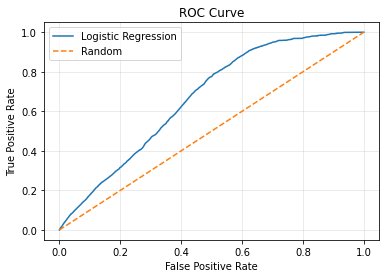

In [9]:
# Predict probabilities for the positive class
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, lr_proba)
auc_score_lr = roc_auc_score(y_test, lr_proba)
print(f"AUC Score: {round(auc_score_lr, 3)}")

# Plot the ROC Curve
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Model 2: Naive Bayes

In [10]:
# Split features (X) and target (y)
X_train_df_NB = pd.DataFrame(X_train, columns=df.drop('Live Birth Occurrence', axis=1).columns) # Features
X_test_df_NB = pd.DataFrame(X_test, columns=df.drop('Live Birth Occurrence', axis=1).columns) # Target

In [11]:
# Define columns to scale for Naive Bayes
scale_cols_NB = [
    'Total Number of Previous IVF cycles', 
    'Total number of IVF pregnancies', 
    'Eggs Thawed', 
    'Eggs Mixed With Partner Sperm', 
    'Embryos Transfered'
]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale numerical columns using column names
X_train_df_NB[scale_cols_NB] = scaler.fit_transform(X_train_df_NB[scale_cols_NB])
X_test_df_NB[scale_cols_NB] = scaler.transform(X_test_df_NB[scale_cols_NB])

# Convert back to NumPy arrays for model compatibility
X_train_scaled_NB = X_train_df_NB.values
X_test_scaled_NB = X_test_df_NB.values

In [12]:
# Initialize Naive Bayes Classifier
classifier_nb = ComplementNB()

# Train the model
classifier_nb.fit(X_train_scaled_NB, y_train)

ComplementNB()

In [13]:
# Make predictions
y_pred_nb = classifier_nb.predict(X_test_scaled_NB)
y_pred_train_nb = classifier_nb.predict(X_train_scaled_NB)

# Calculate and print recall
recall_nb = recall_score(y_test, y_pred_nb)
print(f"Recall: {recall_nb:.3f}")

Recall: 0.676


AUC: 0.634



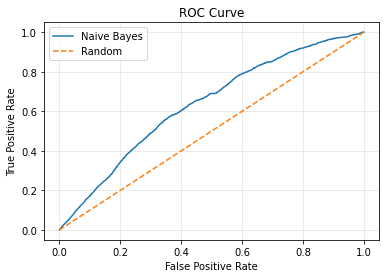

In [14]:
# Predict probabilities for the positive class
bayes_proba = classifier_nb.predict_proba(X_test_scaled_NB)[:, 1]

# Compute ROC curve and AUC
fpr_bayes, tpr_bayes, threshold_bayes = roc_curve(y_test, bayes_proba)
auc_bayes = roc_auc_score(y_test, bayes_proba)
print(f"AUC: {auc_bayes:.3f}\n")

# Plot the ROC Curve
plt.plot(fpr_bayes, tpr_bayes, label='Naive Bayes')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Model 3: Random Forest & Decision Trees

In [15]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [16]:
rf_pred = rf_model.predict(X_test_scaled)

# Calculate and print recall
recall_rf = recall_score(y_test, rf_pred)
print("Recall:", round(recall_rf, 3))

Recall: 0.79


AUC Score: 0.702


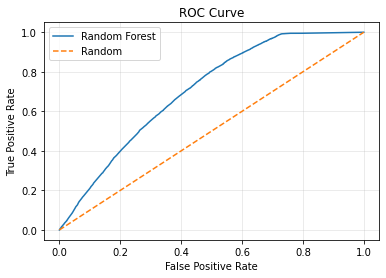

In [17]:
# Predict probabilities for the positive class
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1] 

# Compute ROC curve and AUC
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, rf_proba)
auc_rf = roc_auc_score(y_test, rf_proba)
print("AUC Score:", round(auc_rf, 3))

# Plot the ROC Curve
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Model 4: Gradient Boosting

In [18]:
y_train_series = pd.Series(y_train)

# Initialize Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42, 
    subsample=0.8  # To mitigate overfitting with imbalance
)

# Fit the model with sample weights
gb_model.fit(X_train_scaled, y_train, sample_weight=y_train_series.map({0: 1, 1: 3}))

GradientBoostingClassifier(random_state=42, subsample=0.8)

In [19]:
y_pred_gb = gb_model.predict(X_test_scaled)

# Calculate and print recall
recall_gb = recall_score(y_test, y_pred_gb)
print(f"Recall: {recall_gb:.2f}")

Recall: 0.86


AUC Score: 0.716


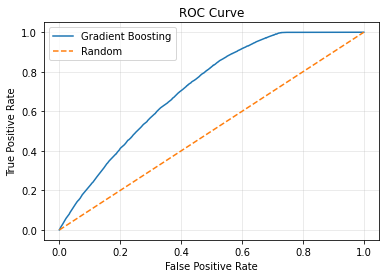

In [20]:
y_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

# Compute ROC curve and AUC
fpr_gb, tpr_gb, threshold_gb = roc_curve(y_test, y_proba_gb)
auc_gb = roc_auc_score(y_test, y_proba_gb)
print(f"AUC Score: {round(auc_gb, 3)}")

# Plot the ROC Curve
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Model Comparison & Evaluation

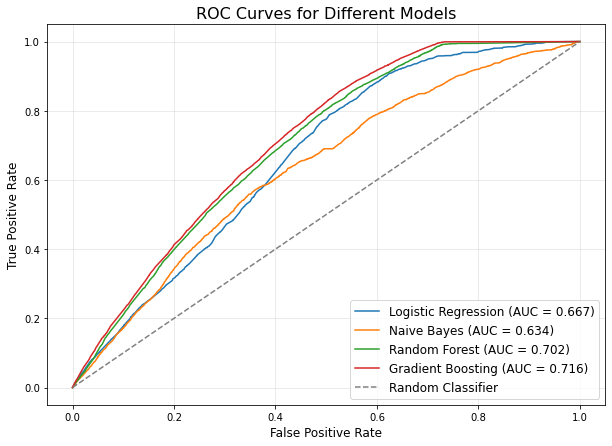

In [21]:
# Plot ROC curves for each model
plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {round(auc_score_lr, 3)})')
plt.plot(fpr_bayes, tpr_bayes, label=f'Naive Bayes (AUC = {round(auc_bayes, 3)})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {round(auc_rf, 3)})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {round(auc_gb, 3)})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')
plt.title('ROC Curves for Different Models', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12, loc='lower right')
plt.show()